# Berechnung der Parameter bei der Reduced-Rank-Regression
(wie in der Ausarbeitung, Satz 3.1 mit entsprechender Stichprobenschätzung)

In [9]:
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

Die folgende Funktion berechnet für Matrizen $\mathcal{X} = (\mathbf{x}_1,\dots,\mathbf{x}_n) \in \mathbb{R}^{r \times n}$ und $\mathcal{Y} = (\mathbf{y}_1,\dots,\mathbf{y}_n) \in \mathbb{R}^{s \times n}$ von $n$ Beobachtungen (je in den Spalten) von Zufallsvektoren $\mathbf{X}$ und $\mathbf{Y}$ die empirischen Größen

$$\widehat{\mu}_{\mathbf{x}} := \frac{1}{n} \sum_{j=1}^{n} \mathbf{x}_j = \bar{\mathbf{X}}_n \text{,} \quad \widehat{\mu}_{\mathbf{y}} := \frac{1}{n} \sum_{j=1}^{n} \mathbf{y}_j = \bar{\mathbf{y}}_n \text{und}$$

$$\mathbf{x}_{cj} := \mathbf{x}_j - \bar{\mathbf{x}}_n \text{,} \quad \mathbf{y}_{cj} := \mathbf{y}_j - \bar{\mathbf{y}}_n \text{,} \quad \mathcal{X}_c := (\mathbf{x}_{c1},\dots,\mathbf{x}_{cn}) \in \mathbb{R}^{r \times n} \text{,} \quad \mathcal{Y}_c := (\mathbf{y}_{c1},\dots,\mathbf{y}_{cn}) \in \mathbb{R}^{s \times n} \text{,}$$

$$ \widehat{\Sigma}_{\mathbf{X}\mathbf{X}} := \frac{1}{n} \mathcal{X}_c \mathcal{X}_c^\top \in \mathbb{R}^{r \times r} \text{,} \quad \widehat{\Sigma}_{\mathbf{Y}\mathbf{Y}} := \frac{1}{n} \mathcal{Y}_c \mathcal{Y}_c^\top \in \mathbb{R}^{s \times s} \text{,}$$

$$\widehat{\Sigma}_{\mathbf{Y}\mathbf{X}} := \frac{1}{n} \mathcal{Y}_c \mathcal{X}_c^\top = \widehat{\Sigma}_{\mathbf{X}\mathbf{Y}}^\top \in \mathbb{R}^{s \times r} \text{.}$$

In [10]:
def calculate_mean_and_covariance_matrices(X: np.array, Y: np.array) -> (np.array, np.array, np.array, np.array ,np.array):
    assert X.shape[1] == Y.shape[1]
    n = X.shape[1]
    mu_X, mu_Y = np.mean(X, axis=1), np.mean(Y, axis=1)
    X_c, Y_c = X - mu_X[:, None], Y - mu_Y[:, None]
    return mu_X, mu_Y, np.dot(X_c, X_c.T) / n, np.dot(Y_c, X_c.T) / n, np.dot(Y_c, Y_c.T) / n

Die folgende Funktion führt auf Basis der Stichprobenmatrizen $\mathcal{X}$ und $\mathcal{Y}$ (s.o.) die Reduced-Rank-Regression wie in der Ausarbeitung beschrieben durch. Zusätzlich übergeben werden die Gewichtsmatrix $\Gamma$ und der Metaparameter $t$. Zurückgegeben werden dann:

- $\mu_{\min}^{(t)}$
- $\mathbf{C}_{\min}^{(t)}$
- $(\lambda_1,\dots,\lambda_s)$
- $W_{\Gamma, t}(\mu_{\min}^{(t)}, \mathbf{C}_{\min}^{(t)}, \Gamma)$

mit der Notation aus der Ausarbeitung.

In [11]:
def reduced_rank_regression(X: np.array, Y: np.array, Gamma: np.array, t: int) -> (np.array, np.array, np.array, float):
    assert t <= Y.shape[0]
    assert Y.shape[0] <= X.shape[0]
    assert X.shape[1] == Y.shape[1]
    assert Gamma.shape == (Y.shape[0], Y.shape[0])
    mu_X, mu_Y, Sigma_XX, Sigma_YX, Sigma_YY = calculate_mean_and_covariance_matrices(X, Y)
    U, S, _ = np.linalg.svd(np.dot(np.dot(fractional_matrix_power(Gamma, 0.5), Sigma_YX), 
                                   fractional_matrix_power(Sigma_XX, -0.5)))
    C_min = np.dot(np.dot(np.dot(fractional_matrix_power(Gamma, -0.5), np.dot(U[:,0:t], U[:,0:t].T)), 
                   fractional_matrix_power(Gamma, 0.5)), np.dot(Sigma_YX, np.linalg.inv(Sigma_XX)))
    mu_min = mu_Y - np.dot(C_min, mu_X)
    min_value = np.trace(Sigma_YY) * np.trace(Gamma) - np.sum(S[0:t])
    return mu_min, C_min, S, min_value

Wir wenden die Reduced-Rank-Regression nun an einem simulierten Beispiel an. Dafür erzeugen wir je $n=1000$ unabhängige Realisierungen 

$$\mathbf{x}_j\text{,} \quad \varepsilon_j \text{,}\quad 1 \leq j \leq n \text{,}$$

wobei die $\mathbf{x}_j$ einer $\mathcal{N}_3(\mathbf{0}, \; 0.3 \cdot \mathbf{I}_3)$-Verteilung und die $\varepsilon_j$ einer $\mathcal{N}_3(\mathbf{0}, \; 0.15 \cdot \mathbf{I}_3)$-Verteilung entstammen, und setzen $r=s:=3$ sowie

$$\mathbf{C} := \frac{1}{4} \cdot \begin{pmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
0 & 0 & -1
\end{pmatrix} \in \mathbb{R}^{s \times r}\text{,} \quad \mu := \begin{pmatrix}
0.5 \\
0.5 \\
0.5
\end{pmatrix} \text{.}$$

Für $\mathbf{y}_j := \mu + \mathbf{C} \mathbf{x}_j + \varepsilon_j$ ist unsere Stichprobe für die Reduced-Rank-Regression dann

$$\mathcal{D} := \{(\mathbf{x}_j, \mathbf{y}_j) \;|\; 1 \leq i \leq n\}$$

und wir können die Reduced-Rank-Regression durchführen, wobei wir der Einfachheit halber $\Gamma := \mathbf{I}_s$ verwenden.

In [12]:
X = np.random.normal(0, 0.3, size=(3, 1000))
C = 0.25 * np.array([[1, 0, 1],
                     [0, 1, 0],
                     [0, 0, -1]])
mu = np.array([0.5, 0.5, 0.5])
Y = mu[:,None] + np.dot(C, X) + np.random.normal(0, 0.15, size=(3, 1000))

In [13]:
t = 2
rrr_result_values = reduced_rank_regression(X, Y, np.identity(Y.shape[0]), t)
rrr_result_values

(array([0.50282074, 0.50133813, 0.50061235]),
 array([[ 0.22413482,  0.02336612,  0.28959802],
        [ 0.0034762 ,  0.26307837, -0.01867853],
        [-0.12012681,  0.01802582, -0.15790658]]),
 array([0.1194285 , 0.07910847, 0.03797227]),
 0.07418043456664936)

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import *
%matplotlib inline

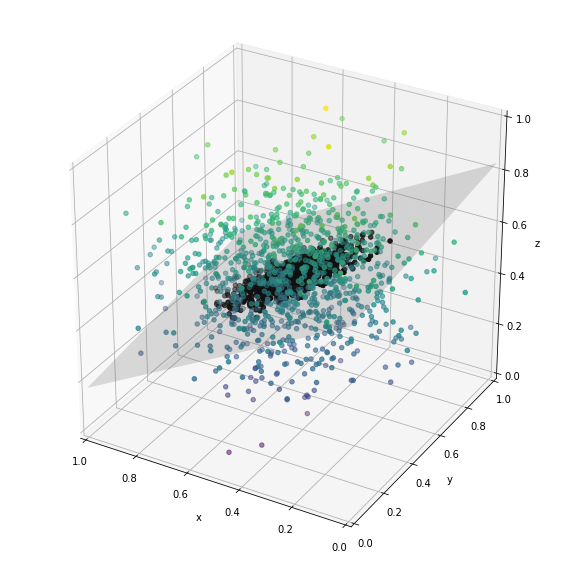

In [15]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)
ax.invert_xaxis()

# Plotte die Datenpunkte
xpts, ypts, zpts = Y[0,:], Y[1,:], Y[2,:]
ax.scatter(xpts, ypts, zpts, c=zpts)
ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('z')

mu_min, C_min, _, _ = rrr_result_values
predY = mu_min[:,None] + np.dot(C_min, X)
xpts, ypts, zpts = predY[0,:], predY[1,:], predY[2,:]
ax.scatter(xpts, ypts, zpts, c='black')

if t == 2:
    # Plotte mögliche Werte für die Approximation mit t=2
    point, C_min, _, _ = rrr_result_values
    normal = np.cross(C_min[:,0], C_min[:,1])
    d = -point.dot(normal)
    xx, yy = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
    z = (-normal[0] * xx - normal[1] * yy - d) / normal[2]
    ax.plot_surface(xx, yy, z, alpha=0.2, color='grey')
fig.tight_layout()

plt.savefig('X_Y_{}_simulated.png'.format(t), dpi=200)